### Project - EuroSoccer Insights: Predicting Outcomes and Analyzing Performance

##### Name: Ananya Agrawal (ananyaa2), Amine Bouayad (abouayad), Ananya Chembai (achembai), Aaditya Hari Nair (aadityah), Aswathama Shanmugam Marimuthu (aswathas)

##### 38615: Computational Modelling, Statistical Analysis and Machine Learning in Science


## Import necessary libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning Libraries
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

### Data Loading

In [8]:
# Display options
pd.set_option("display.max_columns", None)

print("Loading data from SQLite database...")

# Connect to the SQLite database
conn = sqlite3.connect("database.sqlite")

# Load tables into pandas DataFrames
country = pd.read_sql_query("SELECT * FROM Country", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
match = pd.read_sql_query("SELECT * FROM Match", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

print("Data Loaded Successfully.")

# Close the database connection
# conn.close()

# Display basic information
print(f"Number of matches: {match.shape[0]}")
print(f"Number of teams: {team.shape[0]}")
print(f"Number of players: {player.shape[0]}")

Loading data from SQLite database...
Data Loaded Successfully.
Number of matches: 25979
Number of teams: 299
Number of players: 11060


## Data Preprocessing and Merging

In [9]:
# Merge country and league data into match data
match = match.merge(
    country, how="left", left_on="country_id", right_on="id", suffixes=("", "_country")
)
match = match.merge(
    league, how="left", left_on="league_id", right_on="id", suffixes=("", "_league")
)

# Rename columns for clarity
match.rename(
    columns={"name": "country_name", "name_league": "league_name"}, inplace=True
)

# Convert date columns to datetime
match["date"] = pd.to_datetime(match["date"])
team_attributes["date"] = pd.to_datetime(team_attributes["date"])
player_attributes["date"] = pd.to_datetime(player_attributes["date"])
player["birthday"] = pd.to_datetime(player["birthday"])


# Create match outcome variable
# 1 for home win, 0 for draw, -1 for away win
def get_match_result(row):
    if row["home_team_goal"] > row["away_team_goal"]:
        return 1  # Home win
    elif row["home_team_goal"] == row["away_team_goal"]:
        return 0  # Draw
    else:
        return -1  # Away win


match["match_result"] = match.apply(get_match_result, axis=1)


## Exploratory data analysis

### What make a winning team ?

#### Playing at home vs playing away from home 

In [4]:
import plotly.graph_objects as go

def determine_outcome(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 'Home Win'
    elif row['home_team_goal'] < row['away_team_goal']:
        return 'Away Win'
    else:
        return 'Draw'

match['outcome'] = match.apply(determine_outcome, axis=1)

# Calculate the percentages of each unique outcome
outcome_counts = match['outcome'].value_counts(normalize=True) * 100
outcomes = outcome_counts.index.tolist()
percentages = outcome_counts.values.tolist()

colors = ['#D2B48C', '#A0522D', '#8B4513'][:len(outcomes)]  # Adjust for the number of outcomes

fig = go.Figure(data=[
    go.Bar(x=outcomes, y=percentages, marker_color=colors)
])

fig.update_layout(
    title="Percentage of Match Outcomes",
    xaxis_title="Outcome",
    yaxis_title="Percentage",
    template="plotly_white"
)

fig.show()

In [5]:
# Load the datasets
player_df = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data_df = pd.read_sql("SELECT * FROM Team;", conn)
match_df = pd.read_sql("SELECT * FROM Match;", conn)
team_attr_df = pd.read_sql("SELECT * FROM Team_Attributes;", conn)

# Identify player columns in match_df
player_cols = [col for col in match_df.columns if col.startswith('home_player_') or col.startswith('away_player_')]

# Unpivot match_df to have one row per player in a match
match_players = match_df.melt(id_vars=[col for col in match_df.columns if col not in player_cols], 
                              value_vars=player_cols, 
                              var_name='player_position', 
                              value_name='player_api_id')

# Merge player data with match data
merged_match_player_df = match_players.merge(player_df, on='player_api_id', how='left')

# Merge team attributes with team data
merged_team_df = team_attr_df.merge(team_data_df, on='team_api_id', how='left')

# Merge the resulting datasets together on team ids from match data
merged_dataset = merged_match_player_df.merge(merged_team_df, left_on='home_team_api_id', right_on='team_api_id', how='left')

# Display head of final merged dataset
print(merged_dataset.head())


   id_x_x  country_id  league_id     season  stage               date_x  \
0       1           1          1  2008/2009      1  2008-08-17 00:00:00   
1       1           1          1  2008/2009      1  2008-08-17 00:00:00   
2       1           1          1  2008/2009      1  2008-08-17 00:00:00   
3       1           1          1  2008/2009      1  2008-08-17 00:00:00   
4       1           1          1  2008/2009      1  2008-08-17 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492473              9987              9993               1   
2        492473              9987              9993               1   
3        492473              9987              9993               1   
4        492473              9987              9993               1   

   away_team_goal  goal shoton shotoff foulcommit  card cross corner  \
0               1  None   None    None       None 

In [6]:
columns_to_keep = ['overall_rating', 'potential', 'player_fifa_api_id', 'home_team_goal', 'away_team_goal', 
                   'league_id', 'home_team_api_id', 'away_team_api_id', 'match_api_id']
df_filtered = merged_dataset[columns_to_keep]
df = merged_dataset
# Create match_winner column
conditions = [
    (df_filtered['home_team_goal'] > df_filtered['away_team_goal']),
    (df_filtered['home_team_goal'] < df_filtered['away_team_goal']),
    (df_filtered['home_team_goal'] == df_filtered['away_team_goal'])
]
choices = ['Home', 'Away', 'Draw']
df_filtered['match_winner'] = np.select(conditions, choices)
df["match_outcome"] = np.select(conditions, choices)
# Group by league
leagues = df_filtered.groupby('league_id')

# Analyze each league
for league_id, league_data in leagues:
    print(f"\n## League {league_id}")
    
    # Count of matches
    match_count = league_data['match_api_id'].nunique()
    print(f"Total matches: {match_count}")
    
    # Winner statistics
    winner_stats = league_data['match_winner'].value_counts(normalize=True) * 100
    print("\nMatch outcomes:")
    for outcome, percentage in winner_stats.items():
        print(f"{outcome}: {percentage:.2f}%")
    
    # Average goals per match
    avg_home_goals = league_data['home_team_goal'].mean()
    avg_away_goals = league_data['away_team_goal'].mean()
    print(f"\nAverage goals per match:")
    print(f"Home team: {avg_home_goals:.2f}")
    print(f"Away team: {avg_away_goals:.2f}")
    
    # Player statistics
    avg_rating = league_data['overall_rating'].mean()
    avg_potential = league_data['potential'].mean()
    print(f"\nPlayer statistics:")
    print(f"Average overall rating: {avg_rating:.2f}")
    print(f"Average potential: {avg_potential:.2f}")


KeyError: "['overall_rating', 'potential'] not in index"

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Set template and color scheme for all plots
template = 'plotly_white'
color_palette = ['#2E5077', '#558DAB', '#8FB8DE', '#D1A788', '#8E5572']

# 1. Match Outcomes Distribution
fig1 = px.pie(
    values=df['match_outcome'].value_counts(),
    names=df['match_outcome'].value_counts().index,
    title='Match Outcomes Distribution',
    color_discrete_sequence=color_palette,
    template=template
)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=24,
    showlegend=True
)
fig1.show()
# 2. Goals Distribution
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=df['home_team_goal'], name='Home Goals', 
                           marker_color=color_palette[0], opacity=0.7))
fig2.add_trace(go.Histogram(x=df['away_team_goal'], name='Away Goals', 
                           marker_color=color_palette[2], opacity=0.7))
fig2.update_layout(
    title='Distribution of Home vs Away Goals',
    xaxis_title='Goals Scored',
    yaxis_title='Frequency',
    barmode='overlay',
    template=template,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=24
)
fig2.show()
# 3. League Performance
league_outcomes = df.groupby('league_id')['match_outcome'].value_counts(normalize=True).unstack() * 100
fig3 = px.bar(
    league_outcomes,
    title='Match Outcomes by League',
    color_discrete_sequence=color_palette,
    template=template,
    barmode='group'
)
fig3.update_layout(
    xaxis_title='League ID',
    yaxis_title='Percentage (%)',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=24
)
fig3.show()
# 4. Team Attributes Radar Chart
team_attrs = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 
              'chanceCreationShooting', 'defencePressure', 'defenceAggression']
team_means = df[team_attrs].mean()

fig4 = go.Figure()
fig4.add_trace(go.Scatterpolar(
    r=team_means,
    theta=team_attrs,
    fill='toself',
    line_color=color_palette[0]
))
fig4.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    showlegend=False,
    title='Average Team Attributes',
    template=template,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=24
)
fig4.show()
# Update layout settings for all figures
for fig in [fig1, fig2, fig3, fig4]:
    fig.update_layout(
        font=dict(family="Arial", size=14),
        title_x=0.5,
        margin=dict(t=100, l=50, r=50, b=50)
    )


NameError: name 'df' is not defined

#### Online gambling companies performance

In [ ]:
# Function to calculate prediction accuracy for a set of odds
def calculate_prediction_accuracy(matches, home_odds_col, draw_odds_col, away_odds_col, label):
    matches[f'{label}_implied_home_prob'] = 1 / matches[home_odds_col]
    matches[f'{label}_implied_draw_prob'] = 1 / matches[draw_odds_col]
    matches[f'{label}_implied_away_prob'] = 1 / matches[away_odds_col]

    # Normalize probabilities
    total_prob = (matches[f'{label}_implied_home_prob'] +
                  matches[f'{label}_implied_draw_prob'] +
                  matches[f'{label}_implied_away_prob'])
    matches[f'{label}_implied_home_prob'] /= total_prob
    matches[f'{label}_implied_draw_prob'] /= total_prob
    matches[f'{label}_implied_away_prob'] /= total_prob

    # Predict the outcome based on the highest implied probability
    matches[f'{label}_predicted_outcome'] = matches[
        [f'{label}_implied_home_prob', f'{label}_implied_draw_prob', f'{label}_implied_away_prob']
    ].idxmax(axis=1).replace({
        f'{label}_implied_home_prob': 'Home Win',
        f'{label}_implied_draw_prob': 'Draw',
        f'{label}_implied_away_prob': 'Away Win'
    })

    # Determine actual outcome
    matches['outcome'] = matches[['home_team_goal', 'away_team_goal']].apply(
        lambda row: 'Home Win' if row[0] > row[1] else ('Away Win' if row[0] < row[1] else 'Draw'),
        axis=1
    )

    # Check if the prediction was correct
    matches[f'{label}_correct_prediction'] = matches['outcome'] == matches[f'{label}_predicted_outcome']

    # Calculate percentage of correct and incorrect predictions
    summary = matches[f'{label}_correct_prediction'].value_counts(normalize=True).reset_index()
    summary.columns = ['prediction_accuracy', 'percentage']
    summary['prediction_accuracy'] = summary['prediction_accuracy'].replace({True: 'Correct', False: 'Incorrect'})
    summary['model'] = label
    return summary

bet_click_summary = calculate_prediction_accuracy(match, 'B365H', 'B365D', 'B365A', 'Bet Click')

bet_win_summary = calculate_prediction_accuracy(match, 'BWH', 'BWD', 'BWA', 'Bet&Win')

combined_summary = pd.concat([bet_click_summary, bet_win_summary], ignore_index=True)

# Plot with Plotly
fig = px.bar(
    combined_summary,
    x='model',
    y='percentage',
    color='prediction_accuracy',
    barmode='group',
    text='percentage',
    labels={'model': 'Model', 'percentage': 'Percentage', 'prediction_accuracy': 'Prediction Accuracy'},
    title='Prediction Accuracy: Bet Click vs Bet&Win',
    color_discrete_map={'Correct': '#D2B48C', 'Incorrect': '#A0522D'}
)

fig.update_traces(texttemplate='%{text:.2%}')

fig.show()

### Let's see how our favorite players did

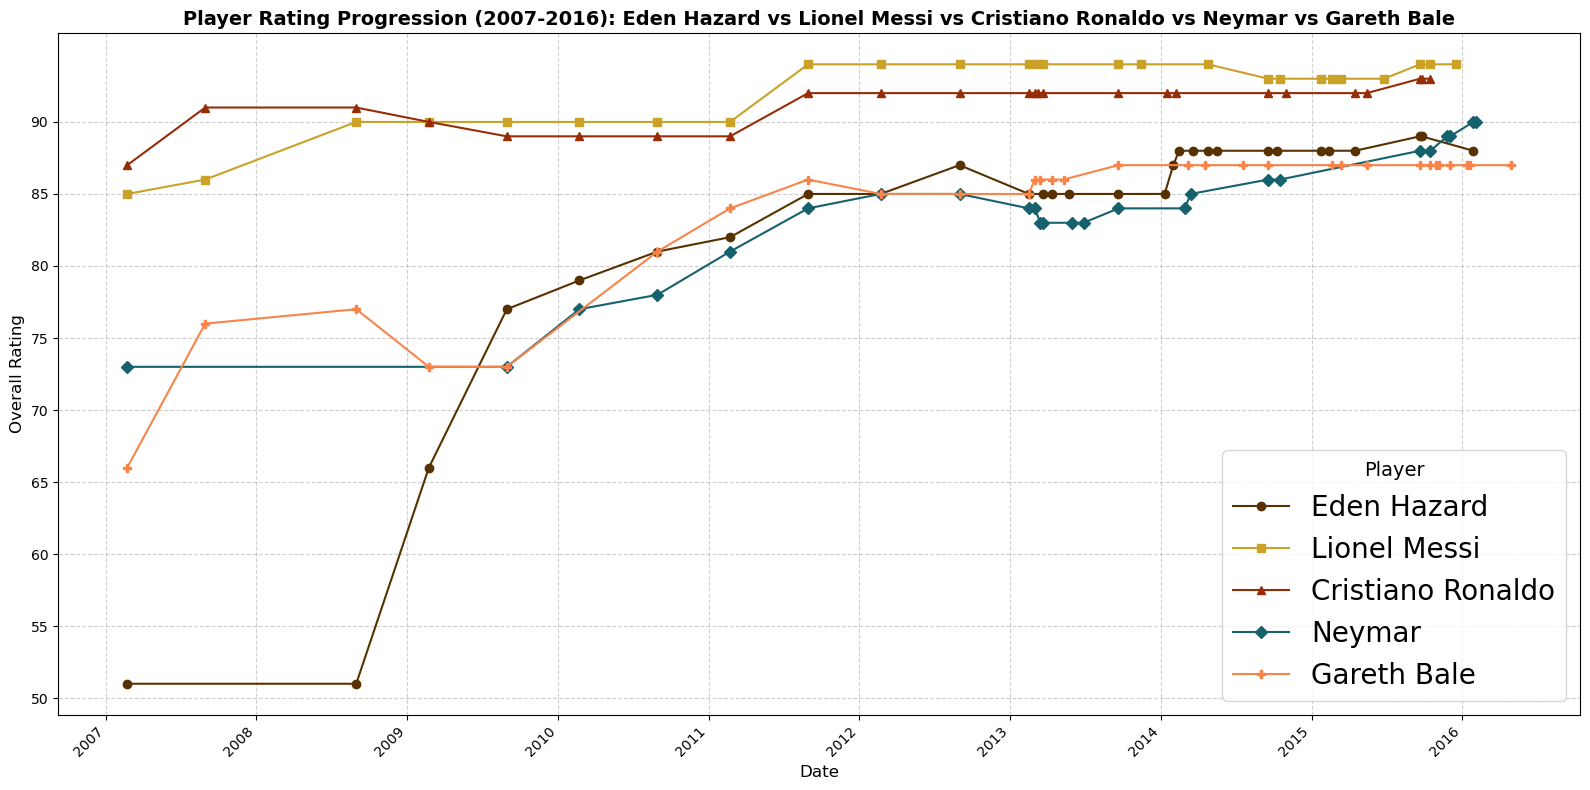

In [10]:
def plot_player_progression(player_names, conn, start_date='2007-01-01', end_date='2016-12-31'):
    query = f"""
        SELECT Player.player_name, Player_Attributes.date, Player_Attributes.overall_rating
        FROM Player
        LEFT JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id
        WHERE Player.player_name IN ({', '.join([f"'{name}'" for name in player_names])})
          AND Player_Attributes.date BETWEEN '{start_date}' AND '{end_date}'
        ORDER BY Player_Attributes.date;
    """

    player_progression = pd.read_sql(query, conn)
    
    player_progression['date'] = pd.to_datetime(player_progression['date'])

    colors = ['#583101', '#c9a227', '#972d07', '#15616d', '#f9844a', 'black']
    markers = ['o', 's', '^', 'D', 'P', '*']

    plt.figure(figsize=(16, 8))

    for i, player in enumerate(player_names):
        player_data = player_progression[player_progression['player_name'] == player]
        plt.plot(player_data['date'], player_data['overall_rating'], 
                 marker=markers[i % len(markers)], 
                 color=colors[i % len(colors)], 
                 linestyle='-', 
                 label=player)

    plt.title(f"Player Rating Progression ({start_date[:4]}-{end_date[:4]}): {' vs '.join(player_names)}", fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Overall Rating', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(range(50, 95, 5))  
    plt.legend(title='Player', fontsize=20, title_fontsize=14, loc='lower right')  
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()  
    plt.show()

plot_player_progression(['Eden Hazard', 'Lionel Messi', 'Cristiano Ronaldo', 'Neymar', 'Gareth Bale'], conn)

### What affects their performance?

In [11]:
player_attributes = player_attributes.drop(columns=['date', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate'], axis=1)

correlation_matrix  = player_attributes.corr()
corr_values = correlation_matrix["overall_rating"]

high_corr_columns = corr_values[corr_values > 0.4]
print(high_corr_columns)

overall_rating    1.000000
potential         0.766757
short_passing     0.458361
long_passing      0.435018
ball_control      0.444257
reactions         0.769246
shot_power        0.427996
vision            0.431137
Name: overall_rating, dtype: float64


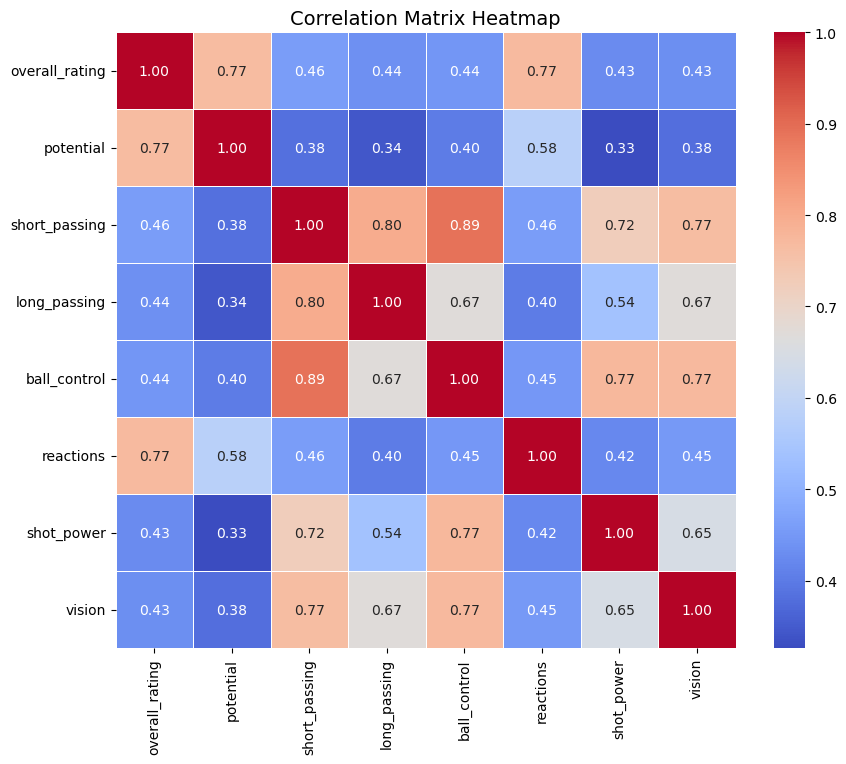

In [12]:
high_corr_columns = [
    "overall_rating", 
    "potential", 
    "short_passing", 
    "long_passing", 
    "ball_control", 
    "reactions", 
    "shot_power", 
    "vision"
]

filtered_df = player_attributes[high_corr_columns]

filtered_corr_matrix = filtered_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.show()

### Average goals per country over time

<Axes: title={'center': 'Average Goals per Game Over Time'}>

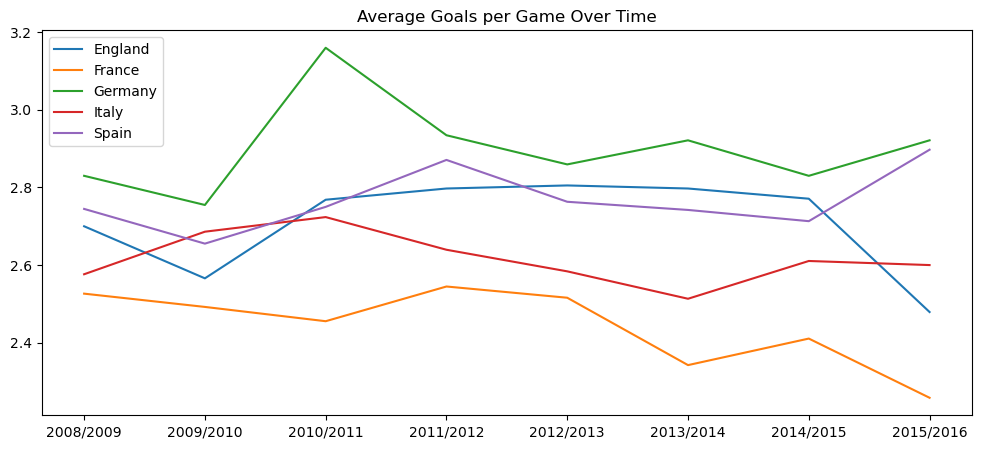

In [13]:
leagues_by_season = pd.read_sql("""select Country.name as country_name,
                                          League.name as league_name,
                                          season,
                                          count(distinct stage) AS number_of_stages,
                                          count(distinct HT.team_long_name) AS number_of_teams,
                                          avg(home_team_goal) AS avg_home_team_goals, 
                                          avg(away_team_goal) AS avg_away_team_goals, 
                                          avg(home_team_goal-away_team_goal) AS avg_goal_diff,
                                          avg(home_team_goal+away_team_goal) AS avg_goals, 
                                          sum(home_team_goal+away_team_goal) AS total_goals
                                    FROM Match
                                    JOIN Country on Country.id = Match.country_id
                                    JOIN League on League.id = Match.league_id
                                    LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                    LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                    WHERE country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                    GROUP BY Country.name, League.name, season
                                    HAVING count(distinct stage) > 10
                                    ORDER BY Country.name, League.name, season DESC
                                          ;""", conn) 


dataframe = pd.DataFrame(index = np.sort(leagues_by_season['season'].unique()),columns = leagues_by_season['country_name'].unique())
dataframe.loc[:,'Germany'] = list(leagues_by_season.loc[leagues_by_season['country_name']=='Germany','avg_goals'])
dataframe.loc[:,'Spain']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Spain','avg_goals'])
dataframe.loc[:,'France']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='France','avg_goals'])
dataframe.loc[:,'Italy']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Italy','avg_goals'])
dataframe.loc[:,'England']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='England','avg_goals'])

dataframe.plot(figsize=(12,5),title='Average Goals per Game Over Time')

### Feature Engineering

In [4]:
# --- Team Attributes ---

# Define the columns to use from team_attributes
team_attribute_cols = [
    "buildUpPlaySpeed",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]


# Prepare team attributes by selecting the most recent attributes before the match date
def get_team_attributes(team_id, match_date):
    attributes = team_attributes[team_attributes["team_api_id"] == team_id]
    attributes = attributes[attributes["date"] <= match_date]
    attributes = attributes.sort_values(by="date", ascending=False)
    if not attributes.empty:
        attributes = attributes.iloc[0]
        return attributes[team_attribute_cols]
    else:
        # Return a Series with NaNs and correct index
        return pd.Series([np.nan] * len(team_attribute_cols), index=team_attribute_cols)


# Apply the function to get team attributes for home and away teams
print("Extracting team attributes...")
home_team_attrs = []
away_team_attrs = []

for idx, row in match.iterrows():
    home_attrs = get_team_attributes(row["home_team_api_id"], row["date"])
    away_attrs = get_team_attributes(row["away_team_api_id"], row["date"])
    home_team_attrs.append(home_attrs)
    away_team_attrs.append(away_attrs)

home_team_attrs_df = pd.DataFrame(home_team_attrs)
away_team_attrs_df = pd.DataFrame(away_team_attrs)

# Add prefixes to columns to distinguish between home and away attributes
home_team_attrs_df = home_team_attrs_df.add_prefix("home_")
away_team_attrs_df = away_team_attrs_df.add_prefix("away_")

# Concatenate the attributes to the match data
match = pd.concat(
    [
        match.reset_index(drop=True),
        home_team_attrs_df.reset_index(drop=True),
        away_team_attrs_df.reset_index(drop=True),
    ],
    axis=1,
)

# Check for duplicate columns
duplicate_columns = match.columns[match.columns.duplicated()]
if duplicate_columns.any():
    print(f"Duplicate columns in match DataFrame: {duplicate_columns}")

# --- Player Attributes ---


# Function to get the average player attributes for a team before a match
def get_team_player_attributes(team_id, match_date, player_cols, match_row, team_type):
    # Get player IDs from the team's lineup in the match
    players = []
    for i in range(1, 12):
        player_id = match_row.get(f"{team_type}_player_{i}", None)
        if not pd.isnull(player_id):
            players.append(player_id)
    # Get the most recent attributes for each player
    player_attrs = player_attributes[player_attributes["player_api_id"].isin(players)]
    player_attrs = player_attrs[player_attrs["date"] <= match_date]
    player_attrs = player_attrs.sort_values(by="date", ascending=False).drop_duplicates(
        subset=["player_api_id"], keep="first"
    )
    # Return the average attributes
    if not player_attrs.empty:
        return player_attrs[player_cols].mean()
    else:
        # Return a Series with NaNs and correct index
        return pd.Series([np.nan] * len(player_cols), index=player_cols)


print("Extracting player attributes (this may take a while)...")
team_player_attrs = []

# Define player attributes columns to use
player_cols = [
    "overall_rating",
    "potential",
    "crossing",
    "finishing",
    "heading_accuracy",
    "short_passing",
    "dribbling",
    "long_passing",
    "ball_control",
    "acceleration",
    "sprint_speed",
    "agility",
    "stamina",
    "strength",
    "penalties",
    "marking",
    "standing_tackle",
    "sliding_tackle",
]

# We have expanded the player attributes to include more features

for idx, row in match.iterrows():
    home_player_attrs = get_team_player_attributes(
        row["home_team_api_id"], row["date"], player_cols, row, "home"
    )
    away_player_attrs = get_team_player_attributes(
        row["away_team_api_id"], row["date"], player_cols, row, "away"
    )
    home_player_attrs = home_player_attrs.add_prefix("home_player_")
    away_player_attrs = away_player_attrs.add_prefix("away_player_")
    combined_attrs = pd.concat([home_player_attrs, away_player_attrs], axis=0)
    team_player_attrs.append(combined_attrs)

team_player_attrs_df = pd.DataFrame(team_player_attrs)

# Concatenate player attributes to match data
match = pd.concat(
    [match.reset_index(drop=True), team_player_attrs_df.reset_index(drop=True)], axis=1
)

# --- Recent Team Performance ---


# Function to calculate team's recent performance before a match
def get_recent_performance(team_id, date, n_matches=5):
    team_matches_home = match[
        (match["home_team_api_id"] == team_id) & (match["date"] < date)
    ]
    team_matches_away = match[
        (match["away_team_api_id"] == team_id) & (match["date"] < date)
    ]
    team_matches = pd.concat([team_matches_home, team_matches_away]).sort_values(
        by="date", ascending=False
    )
    team_matches = team_matches.head(n_matches)
    if not team_matches.empty:
        results = []
        for idx, row in team_matches.iterrows():
            if row["home_team_api_id"] == team_id:
                if row["match_result"] == 1:
                    results.append(1)
                elif row["match_result"] == 0:
                    results.append(0)
                else:
                    results.append(-1)
            else:
                if row["match_result"] == -1:
                    results.append(1)
                elif row["match_result"] == 0:
                    results.append(0)
                else:
                    results.append(-1)
        return np.mean(results)
    else:
        return 0


print("Calculating recent team performance...")
home_recent_performance = []
away_recent_performance = []

for idx, row in match.iterrows():
    home_perf = get_recent_performance(row["home_team_api_id"], row["date"])
    away_perf = get_recent_performance(row["away_team_api_id"], row["date"])
    home_recent_performance.append(home_perf)
    away_recent_performance.append(away_perf)

match["home_recent_performance"] = home_recent_performance
match["away_recent_performance"] = away_recent_performance

# --- Head-to-Head Statistics ---


# Function to calculate head-to-head statistics
def get_head_to_head(home_team_id, away_team_id, date):
    h2h_matches = match[
        (
            (match["home_team_api_id"] == home_team_id)
            & (match["away_team_api_id"] == away_team_id)
        )
        | (
            (match["home_team_api_id"] == away_team_id)
            & (match["away_team_api_id"] == home_team_id)
        )
    ]
    h2h_matches = h2h_matches[h2h_matches["date"] < date].sort_values(
        by="date", ascending=False
    )
    h2h_matches = h2h_matches.head(5)
    if not h2h_matches.empty:
        results = []
        for idx, row in h2h_matches.iterrows():
            if row["home_team_api_id"] == home_team_id and row["match_result"] == 1:
                results.append(1)
            elif row["away_team_api_id"] == home_team_id and row["match_result"] == -1:
                results.append(1)
            elif row["match_result"] == 0:
                results.append(0)
            else:
                results.append(-1)
        return np.mean(results)
    else:
        return 0


print("Calculating head-to-head statistics...")
h2h_performance = []

for idx, row in match.iterrows():
    h2h_perf = get_head_to_head(
        row["home_team_api_id"], row["away_team_api_id"], row["date"]
    )
    h2h_performance.append(h2h_perf)

match["head_to_head"] = h2h_performance

# --- Categorical Encoding ---

# Corrected column names (fixed 'defenceDefensiveLineClass' to 'defenceDefenderLineClass')
categorical_cols = [
    "home_buildUpPlayPositioningClass",
    "home_chanceCreationPositioningClass",
    "home_defenceDefenderLineClass",
    "away_buildUpPlayPositioningClass",
    "away_chanceCreationPositioningClass",
    "away_defenceDefenderLineClass",
]

# Replace missing categorical values with a placeholder
for col in categorical_cols:
    if col in match.columns:
        match[col].fillna("Unknown", inplace=True)
        match[col] = match[col].astype("category").cat.codes

# --- Feature Selection ---

# Select relevant features
features = [

    # Team attributes
    "home_buildUpPlaySpeed",
    "home_buildUpPlayPassing",
    "home_chanceCreationPassing",
    "home_chanceCreationCrossing",
    "home_chanceCreationShooting",
    "home_defencePressure",
    "home_defenceAggression",
    "home_defenceTeamWidth",
    "away_buildUpPlaySpeed",
    "away_buildUpPlayPassing",
    "away_chanceCreationPassing",
    "away_chanceCreationCrossing",
    "away_chanceCreationShooting",
    "away_defencePressure",
    "away_defenceAggression",
    "away_defenceTeamWidth",

    # Player attributes
    "home_player_overall_rating",
    "home_player_potential",
    "home_player_crossing",
    "home_player_finishing",
    "home_player_heading_accuracy",
    "home_player_short_passing",
    "home_player_dribbling",
    "home_player_long_passing",
    "home_player_ball_control",
    "home_player_acceleration",
    "home_player_sprint_speed",
    "home_player_agility",
    "home_player_stamina",
    "home_player_strength",
    "home_player_penalties",
    "home_player_marking",
    "home_player_standing_tackle",
    "home_player_sliding_tackle",
    "away_player_overall_rating",
    "away_player_potential",
    "away_player_crossing",
    "away_player_finishing",
    "away_player_heading_accuracy",
    "away_player_short_passing",
    "away_player_dribbling",
    "away_player_long_passing",
    "away_player_ball_control",
    "away_player_acceleration",
    "away_player_sprint_speed",
    "away_player_agility",
    "away_player_stamina",
    "away_player_strength",
    "away_player_penalties",
    "away_player_marking",
    "away_player_standing_tackle",
    "away_player_sliding_tackle",
    
    # Head-to-head
    "head_to_head"
]

# Ensure all features exist in the match DataFrame
existing_features = [col for col in features if col in match.columns]
missing_features = [col for col in features if col not in match.columns]
if missing_features:
    print(
        f"The following features are missing and will be excluded: {missing_features}"
    )

# Remove any rows with missing values in the features or target variable
print("Cleaning data by dropping rows with missing values in selected features...")
match_cleaned = match.dropna(subset=existing_features + ["match_result"])
print(f"Data size before cleaning: {match.shape[0]} rows")
print(f"Data size after cleaning: {match_cleaned.shape[0]} rows")

X = match_cleaned[existing_features]
y = match_cleaned["match_result"]

# Convert target variable to numeric classes (0,1,2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
print("Handling class imbalance using SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)


Extracting team attributes...
Extracting player attributes (this may take a while)...
Calculating recent team performance...
Calculating head-to-head statistics...
Cleaning data by dropping rows with missing values in selected features...
Data size before cleaning: 25979 rows
Data size after cleaning: 19355 rows
Handling class imbalance using SMOTE...


### Model Training and Evaluation

In [ ]:
# Split data into training and  hidden test sets
print("Splitting data into training and test sets...")
X_train1, X_test_hidden, y_train1, y_test_hidden = train_test_split(
    X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42
)
# Split available data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train1 ,y_train1, test_size=0.2, stratify=y_train1, random_state=42
)


# Define models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Support Vector Machine": SVC(probability=True, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "LightGBM": LGBMClassifier(),
    "Adaboost": AdaBoostClassifier(
        n_estimators=50,
        random_state=42,
    ),
}

# Train and evaluate models using cross-validation
print("\nTraining and evaluating models...")
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

predictions = {}
model_store = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    print(
        f"{name} Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})"
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    predictions[name] = y_pred
    print(f"{name} Test Accuracy: {acc:.4f}")
    results[name] = acc
    model_store[name] = model

# Display models ranked by test accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nModels ranked by test accuracy:")
for name, acc in sorted_results:
    print(f"{name}: {acc:.4f}")


Splitting data into training and test sets...

Training and evaluating models...

Training Logistic Regression...
Logistic Regression Cross-validation Accuracy: 0.4585 (+/- 0.0049)
Logistic Regression Test Accuracy: 0.4675

Training Support Vector Machine...
Support Vector Machine Cross-validation Accuracy: 0.5144 (+/- 0.0103)
Support Vector Machine Test Accuracy: 0.5284

Training Random Forest...
Random Forest Cross-validation Accuracy: 0.6371 (+/- 0.0077)
Random Forest Test Accuracy: 0.6572

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13434
[LightGBM] [Info] Number of data points in the train set: 16966, number of used features: 53
[LightGBM] [Info] Start training from score -1.098494
[LightGBM] [Info] Start training from score -1.098671
[LightGBM] [Info] Start training from score -1.098671
[LightGBM] [Info] Auto-choos

### Hyperparameter Tuning for Best Model

In [6]:
best_model_name = sorted_results[0][0]
print(f"\nHyperparameter Tuning for {best_model_name}...")

if best_model_name == "LightGBM":
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [6, 10, -1],
        "learning_rate": [0.01, 0.1],
        "num_leaves": [31, 50],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
    }
    model = LGBMClassifier()
else:
    # For other models, use generic parameters
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
    }
    model = models[best_model_name]

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters for {best_model_name}: {grid_search.best_params_}")

# Evaluate the best model
print(f"\nEvaluating Best {best_model_name} Model...")
y_pred = best_model.predict(X_test)
print(
    classification_report(
        y_test, y_pred, target_names=label_encoder.classes_.astype(str)
    )
)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")



Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total

### Prediction on Hidden Data

In [ ]:
print(f"\nEvaluating Best {best_model_name} Model...")
Y_pred_hidden= best_model.predict(X_test_hidden)
print(
    classification_report(
        y_test_hidden, Y_pred_hidden, target_names=label_encoder.classes_.astype(str)
    )
)
print(f"Accuracy Score: {accuracy_score(y_test_hidden, Y_pred_hidden):.4f}")

### Prediction on New Data

In [7]:
# For demonstration, let's predict the outcome of the next match in the dataset
print("\nPredicting outcome for a new match...")

# Assuming the next match is at index -1
new_match = match_cleaned.iloc[-1]

# Prepare the feature vector
new_match_features = new_match[existing_features].values.reshape(1, -1)
new_match_scaled = scaler.transform(new_match_features)

# Predict using the best model
prediction = best_model.predict(new_match_scaled)
result = label_encoder.inverse_transform(prediction)[0]
outcome = {1: "Home Win", 0: "Draw", -1: "Away Win"}

print(f"Predicted Outcome: {outcome[result]}")



Predicting outcome for a new match...
Predicted Outcome: Home Win


### Generating Plots for Analysis on Results

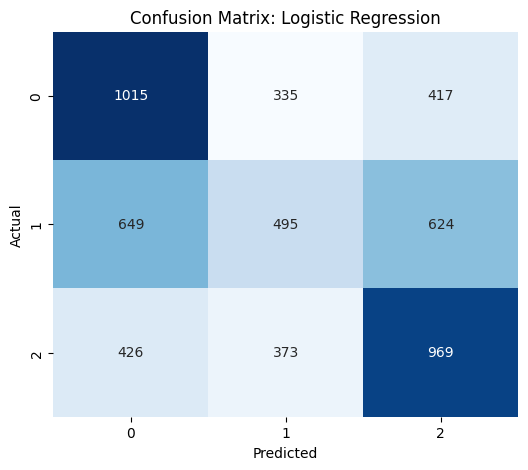

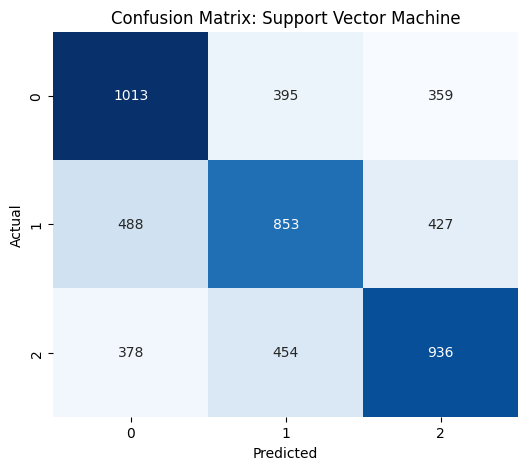

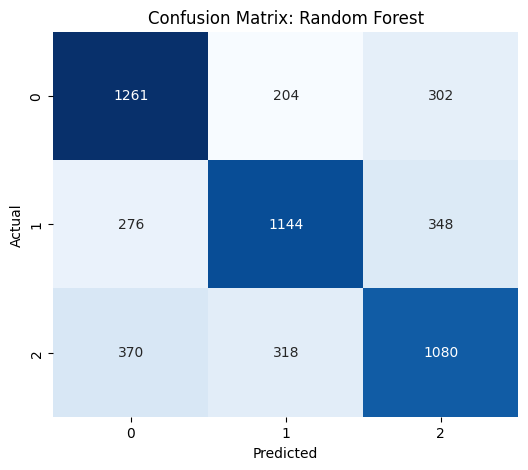

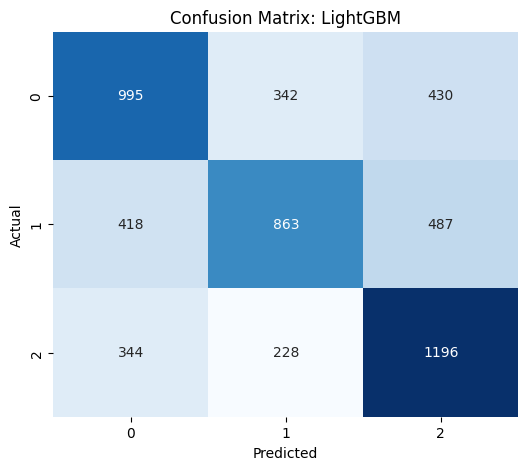

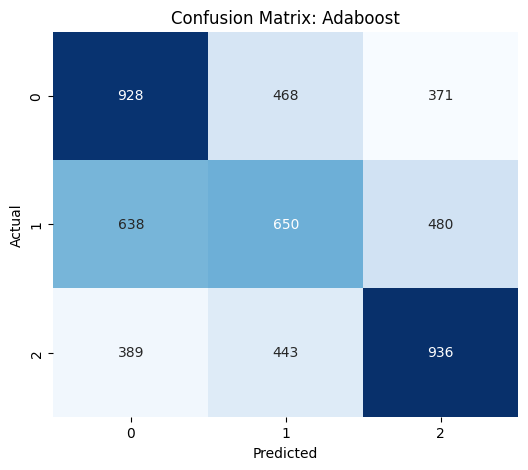

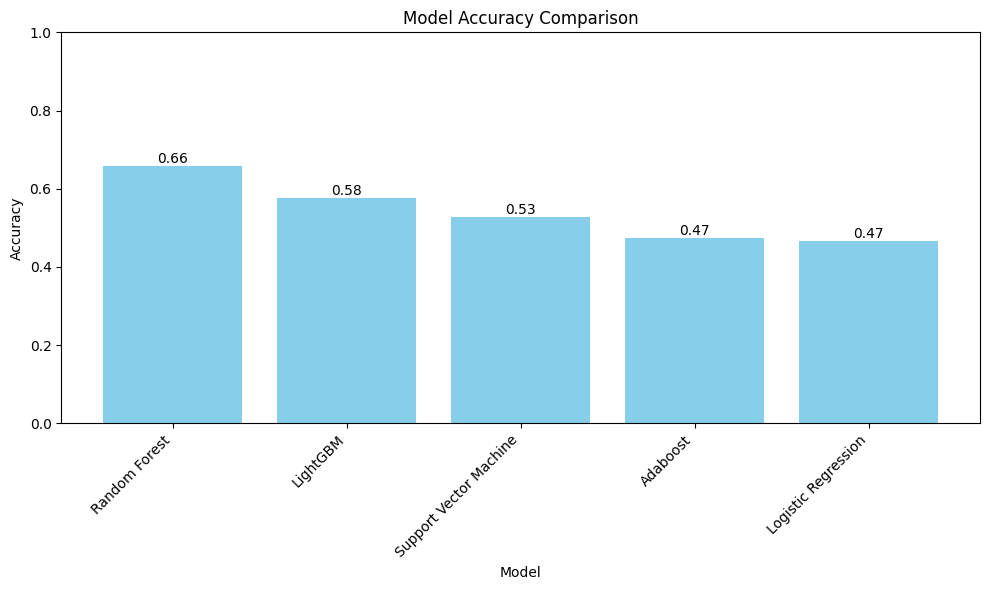

In [8]:
# Plot 1: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for model, pred in predictions.items():
    plot_confusion_matrix(y_test, pred, model)

# Plot 2: Accuracy Comparison

# Separate the data into names and values
models, scores = zip(*sorted_results)

accuracies = {model: accuracy_score(y_test, pred) for model, pred in predictions.items()}
plt.figure(figsize=(10, 6))  # Increased the figure size for better readability
bar_plot = plt.bar(models, scores, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align to the right for better visibility
for bar in bar_plot:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


# Plot 3: Feature Importance (for tree-based models)
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[indices], align="center")
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.title(f"Feature Importance: {model_name}")
        plt.tight_layout()
        plt.show()


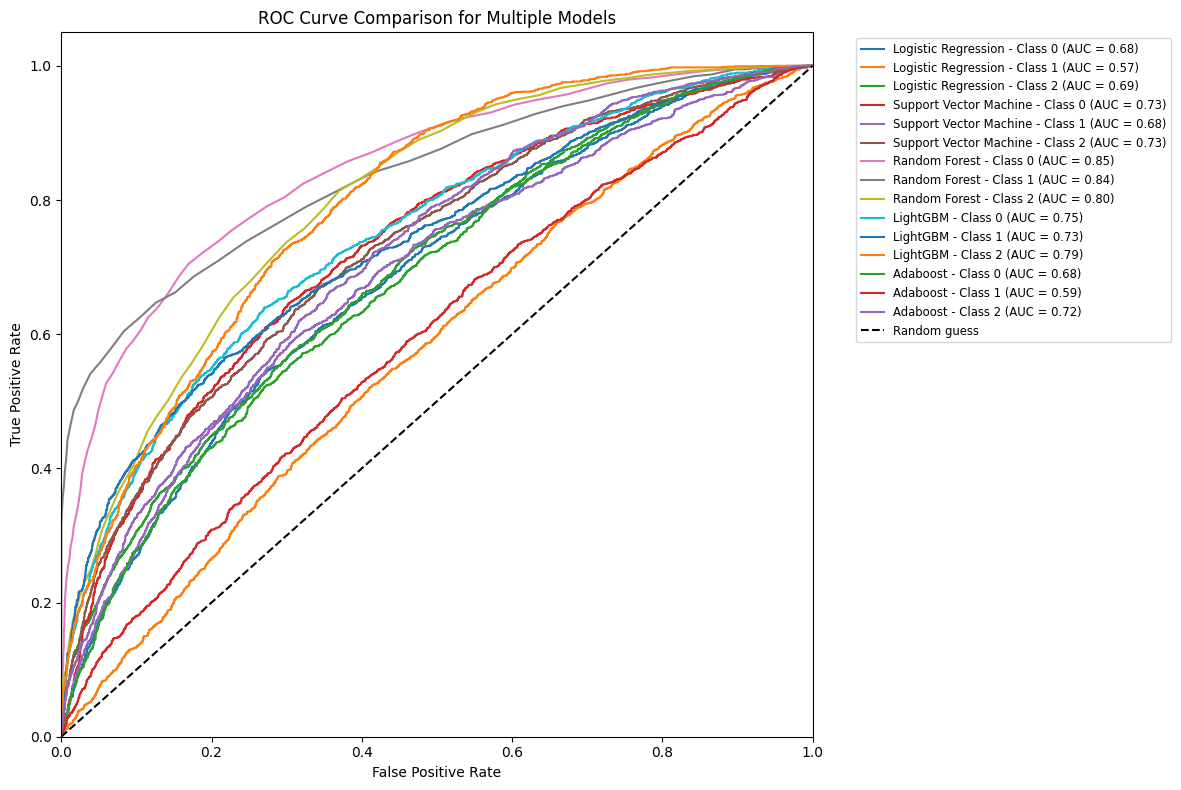

In [13]:
# Binarize the labels for multi-class
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Increase figure size
plt.figure(figsize=(12, 8))

# Iterate through the models
for model_name, model in model_store.items():
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test)
    
    # Plot ROC curve for each class and average them
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - Class {classes[i]} (AUC = {roc_auc:.2f})')

# Add a diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Multiple Models')

# Adjust legend to prevent overlap
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()


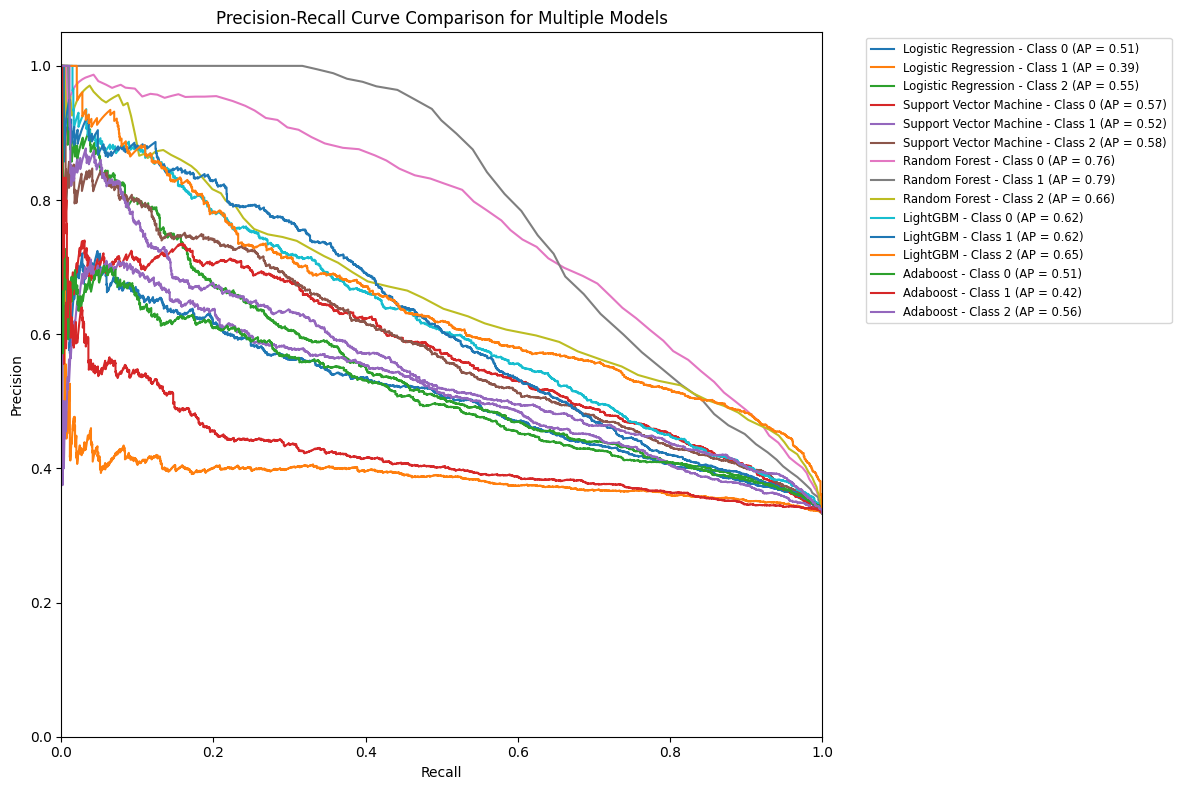

In [14]:
# Binarize the labels for multi-class
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Increase figure size
plt.figure(figsize=(12, 8))

# Iterate through the models
for model_name, model in model_store.items():
    # Get the predicted probabilities
    y_prob = model.predict_proba(X_test)
    
    # Plot Precision-Recall curve for each class and average precision score
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_prob[:, i])
        plt.plot(recall, precision, label=f'{model_name} - Class {classes[i]} (AP = {avg_precision:.2f})')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison for Multiple Models')

# Adjust legend to prevent overlap
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()


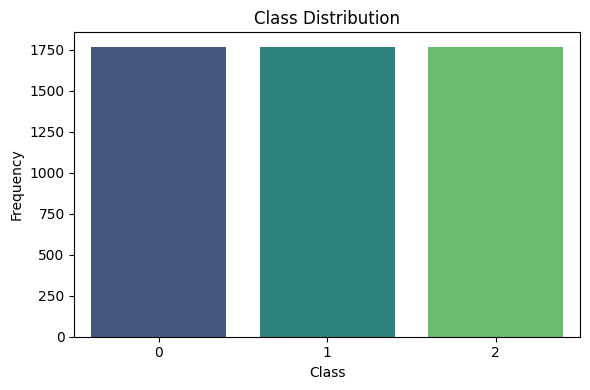

In [15]:
def plot_class_distribution(y_true):
    class_counts = pd.Series(y_true).value_counts()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_test)


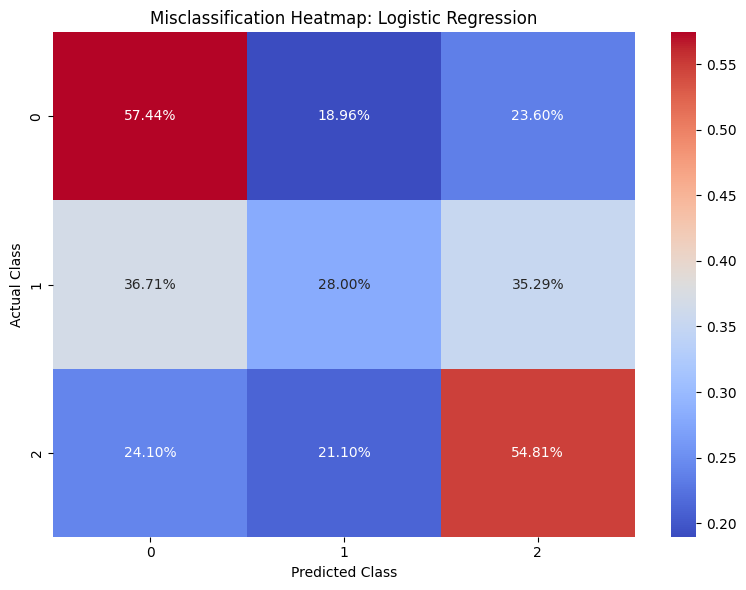

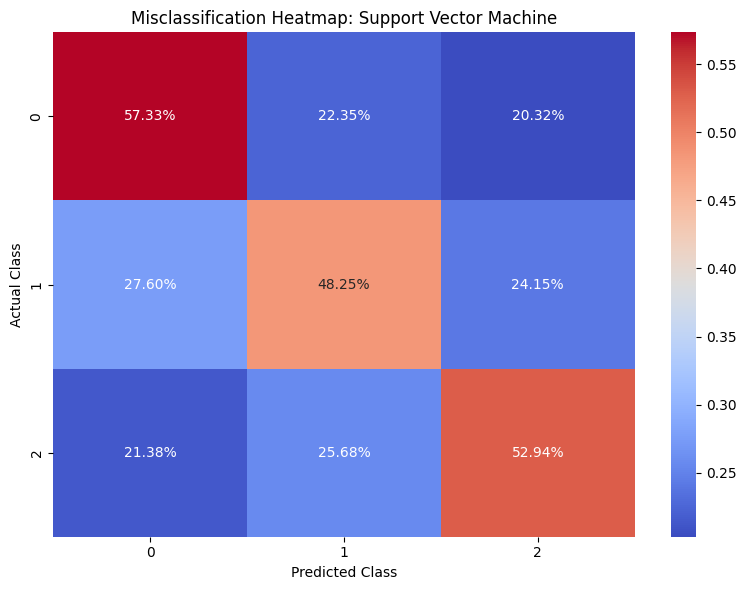

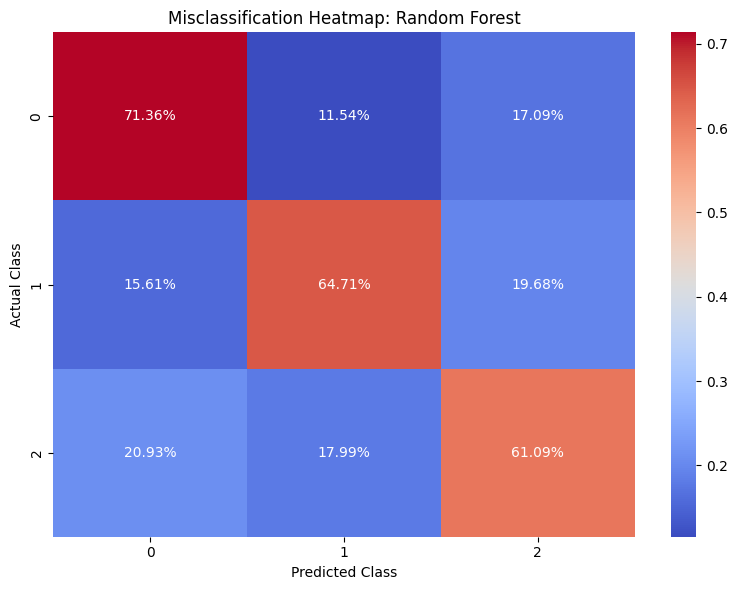

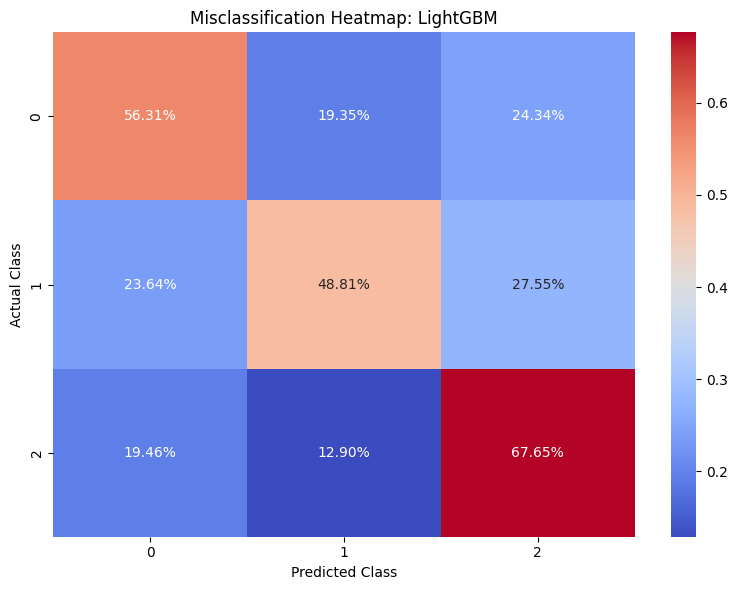

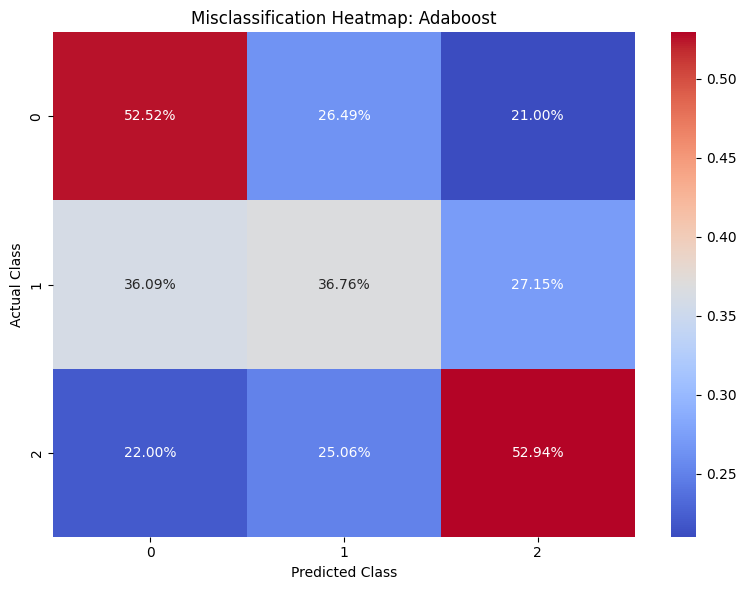

In [16]:
def plot_misclassification_heatmap(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap='coolwarm', fmt='.2%', cbar=True)
    plt.title(f"Misclassification Heatmap: {model_name}")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.tight_layout()
    plt.show()

for model, pred in predictions.items():
    plot_misclassification_heatmap(y_test, pred, model)
